# Computations in arbitrary precision

As hinted in the [expression system tutorial](<./The expression system.ipynb>), starting from version 0.20 heyoka.py supports computations in [arbitrary precision](https://en.wikipedia.org/wiki/Arbitrary-precision_arithmetic) via the ``real`` type.

``real`` is a Python wrapper for the [arbitrary-precision floating-point type](https://bluescarni.github.io/mppp/real.html) from the mp++ library. Before showing how to perform arbitrary-precision computations in heyoka.py, we will go through a quick crash course on the ``real`` type (more details are available in the mp++ [tutorial](https://bluescarni.github.io/mppp/tutorial_real.html) and [reference](https://bluescarni.github.io/mppp/real.html)).

## Getting to know your real self

Let us begin by importing the necessary bits from heyoka.py:

In [1]:
import heyoka as hy
import numpy as np
real = hy.real

``real`` represents arbitrary-precision values encoded in a binary floating-point format. The number of binary digits in the significand (that is, the *precision* of a ``real``) can be set at runtime and it is in principle limited only by the available memory. The precision of a ``real`` object can be queried via the ``prec`` property:

In [2]:
f"The precision of a default-constructed real is: {real().prec} bits"

'The precision of a default-constructed real is: 2 bits'

``real`` objects can be constructed from several other numerical objects. The precision of the constructed ``real`` is automatically inferred to preserve exactly the original value (if possible):

In [3]:
print(f"Precision deduced from a small int  : {real(42).prec} bits")
print(f"Precision deduced from a large int  : {real(2**500).prec} bits")
print(f"Precision deduced from a float      : {real(1.1).prec} bits")
print(f"Precision deduced from a long double: {real(np.longdouble('1.1')).prec} bits")
print(f"Precision deduced from a real128    : {real(hy.real128('1.1')).prec} bits")

Precision deduced from a small int  : 64 bits
Precision deduced from a large int  : 512 bits
Precision deduced from a float      : 53 bits
Precision deduced from a long double: 64 bits
Precision deduced from a real128    : 113 bits


If the automatic deduction is to be avoided, the precision can be specified manually with the ``prec`` keyword argument during construction:

In [4]:
print(f"Precision manually specified from a small int: {real(42, prec=123).prec} bits")
print(f"Precision manually specified from a float    : {real(1.1, prec=12).prec} bits")

Precision manually specified from a small int: 123 bits
Precision manually specified from a float    : 12 bits


Similarly, construction from string **always** requires a precision value to be provided:

In [5]:
real("1.1", prec=128)

1.100000000000000000000000000000000000001

``real`` supports the basic arithmetic and comparison operators. When ``real`` values with different precision are involved in a binary operation, the precision of the result is the largest precision among the operands:

In [6]:
(real("1.1", 128) + real("2.1", 113)).prec

128

In [7]:
(1.1**real("2.1", 256)).prec

256

``real`` also supports several elementary functions, which currently need to be invoked from NumPy:

In [8]:
np.sin(real("1.1", 128))

8.912073600614353399518025778717035383202e-1

In [9]:
np.arctan2(real("1.1", 113), 5.6)

1.93959147259893124733320880625850166e-1

Finally, ``real`` can also be used as a [NumPy data type](https://numpy.org/doc/stable/reference/arrays.dtypes.html):

In [10]:
np.array([1,2,3], dtype=real)

array([1.00000000000000000000, 2.00000000000000000000,
       3.00000000000000000000], dtype=real)

Please be aware that NumPy support is to be considered **experimental** at this time (see the {ref}`"Limitations and caveats"<mp_caveats>` section below).

## Numerical integration

We are now ready to proceed to our first numerical integration in arbitrary precision. In the heyoka.py tradition, we will be using the pendulum as a simple test case.

Let us begin with the definition of the dynamical equations:

In [11]:
# Create the symbolic variables x and v.
x, v = hy.make_vars("x", "v")

# Define the dynamical equations.
sys = [(x, v), (v, -9.8 * hy.sin(x))]

Second, we introduce a small helper to compute the energy of the system. This will be used to track the accuracy of the integration:

In [12]:
def compute_energy(sv):
    from numpy import cos
    return (sv[1]*sv[1])/2 + 9.8*(1 - cos(sv[0]))

For this specific example, we will be performing an integration in [octuple precision](https://en.wikipedia.org/wiki/Octuple-precision_floating-point_format), which requires 237 bits in the significand:

In [13]:
# Store the precision in a constant
# for later use.
prec=237

We can now construct the integrator in octuple precision:

In [14]:
ta = hy.taylor_adaptive(sys,
                        # Initial conditions.
                        [real(-1, prec), real(0, prec)],
                        # Specify that the integrator must operate
                        # in arbitrary precision.
                        fp_type=real)

In order to construct an integrator in arbitrary precision, we need to specify ``fp_type=real`` as a construction argument. By default, the precision is automatically inferred from the precision of the initial state variables: because we passed ``[real(-1, prec), real(0, prec)]`` as initial conditions, heyoka.py deduces that the integration needs to be performed with 237 bits of precision.

As an alternative, the precision can be explicitly passed as a keyword argument:

In [15]:
# Alternative - but equivalent - way of
# setting up an octuple-precision integration.
ta = hy.taylor_adaptive(sys,
                        [real(-1), real(0)],
                        # Specify that the integrator must operate
                        # in arbitrary precision.
                        fp_type=real,
                        # Explicitly specify the precision.
                        prec=prec)

Let us print to screen the integrator object:

In [16]:
ta

C++ datatype            : mppp::v15::real
Precision               : 237 bits
Tolerance               : 9.055679078826712367509119290887791780682531198139138189582614889935501319e-72
High accuracy           : false
Compact mode            : true
Taylor order            : 83
Dimension               : 2
Time                    : 0.000000000000000000000000000000000000000000000000000000000000000000000000
State                   : [-1.000000000000000000000000000000000000000000000000000000000000000000000000, 0.000000000000000000000000000000000000000000000000000000000000000000000000]

Like with standard double-precision integrations, the default tolerance value is the epsilon corresponding to the integration precision. Note also how, for arbitrary-precision integrations, compact mode defaults to ``True`` rather than ``False``.
This change is motivated by the fact that the Taylor order of arbitrary-precision integrators will typically be much higher than in double-precision and extended-precision integrators, which results in very long compilation times even for simple ODEs. Moreover, in arbitrary-precision integrators compact mode does not bring substantial performance improvements due to the fact that most numerical computations are offloaded to the mp++ library (rather than being implemented directly in LLVM).

Let us now compute and store the initial energy of the system:

In [17]:
E0 = compute_energy(ta.state)

Next, let us propagate the system until ``t=5``, requesting the [continuous output](<./Dense output.ipynb>):

In [18]:
out = ta.propagate_until(real(5), c_output=True)

We can now use the continuous output to compute how the energy error evolves throughout the integration:

In [19]:
# Define a time grid in octuple precision.
tgrid = np.linspace(real(0, prec), real(5, prec), 1000)

# Compute the relative energy error over the time grid.
Eerr = [abs((compute_energy(_) - E0)/E0) for _ in out[-2](tgrid)]

Let us plot the energy error:

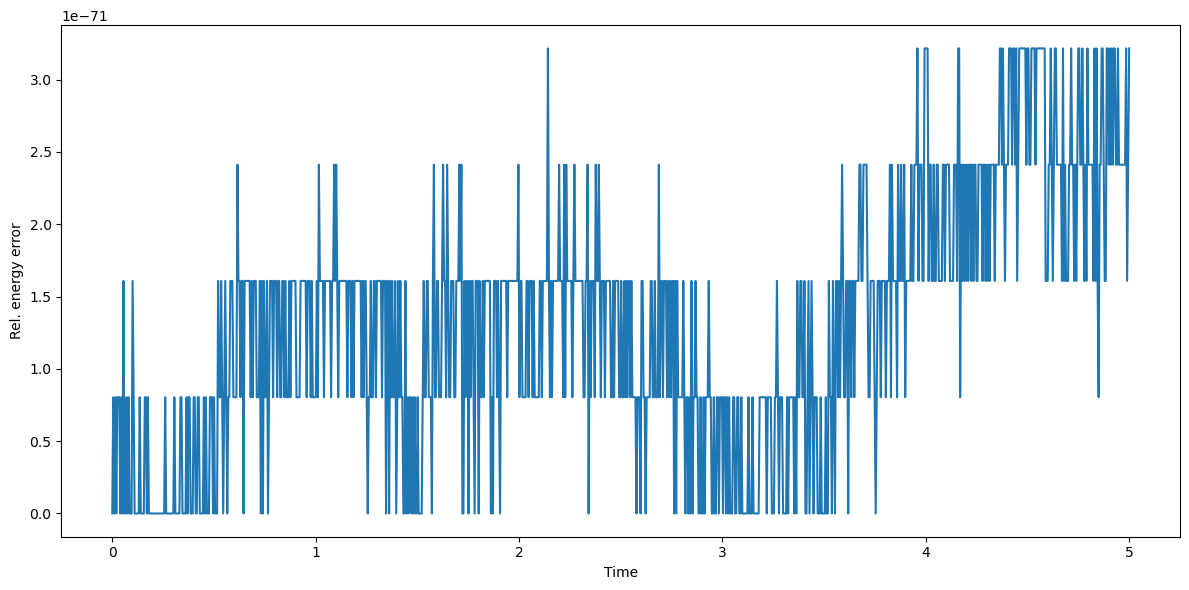

In [20]:
%matplotlib inline
from matplotlib.pylab import plt

fig = plt.figure(figsize=(12, 6))

plt.plot(tgrid, Eerr)

plt.xlabel("Time")
plt.ylabel("Rel. energy error")

plt.tight_layout()

We can see how indeed energy is preserved at the requested accuracy level.

All features available in double precision are also available in arbitrary precision. For instance, here's an example of arbitrary-precision event detection from the [event detection tutorial](<./Event detection.ipynb>):

In [21]:
# Define a callback for the event.
def cb(ta, time, d_sgn):
    # Compute the state of the system when the
    # event triggered and print the value of x.
    ta.update_d_output(time)
    print("Value of x when v is zero: {}".format(ta.d_output[0]))

ev = hy.nt_event(
        # The left-hand side of the event equation
        v,
        # The callback.
        callback = cb,
        # Specify this is an event
        # for arbitrary-precision
        # integration.
        fp_type = real)

ta = hy.taylor_adaptive(
        # Definition of the ODE system:
        # x' = v
        # v' = -9.8 * sin(x)
        ((x, v), (v, -9.8 * hy.sin(x))),
        # Initial conditions
        # for x and v.
        [real("-0.05", prec), real(0., prec)],
        # Non-terminal events.
        nt_events = [ev],
        # Specify this is an
        # arbitrary-precision
        # integration.
        fp_type = real)

ta.propagate_until(real(10));

Value of x when v is zero: -5.000000000000000000000000000000000000000000000000000000000000000000000011e-2
Value of x when v is zero: 5.000000000000000000000000000000000000000000000000000000000000000000000011e-2
Value of x when v is zero: -4.999999999999999999999999999999999999999999999999999999999999999999999983e-2
Value of x when v is zero: 5.000000000000000000000000000000000000000000000000000000000000000000000011e-2
Value of x when v is zero: -5.000000000000000000000000000000000000000000000000000000000000000000000011e-2
Value of x when v is zero: 5.000000000000000000000000000000000000000000000000000000000000000000000011e-2
Value of x when v is zero: -5.000000000000000000000000000000000000000000000000000000000000000000000011e-2
Value of x when v is zero: 5.000000000000000000000000000000000000000000000000000000000000000000000040e-2
Value of x when v is zero: -5.000000000000000000000000000000000000000000000000000000000000000000000040e-2
Value of x when v is zero: 5.000000000000000000000

In this example, the event is supposed to trigger whenever the pendulum's bob reaches the maximum amplitude, which corresponds to $v=0$ and $\left|x\right|=0.05$. We can see from the screen output that this is indeed the case.

## Compiled functions

[Compiled functions](<./compiled_functions.ipynb>) are also available in arbitrary precision. Here's a simple example:

In [22]:
x,y = hy.make_vars("x", "y")

# Define the function to be compiled.
sym_func = x**2-y**2

# Compile it.
cf = hy.make_cfunc([sym_func], fp_type=real, prec=prec)

Note that, in addition to specifying ``fp_type=real``, we also **must** explicitly specify the precision of the compiled function. That is, compiled functions cannot automatically determine a precision value from their inputs.

We can now proceed to the evaluation of the compiled function:

In [23]:
cf([real(1, prec), real(2, prec)])

array([-3.000000000000000000000000000000000000000000000000000000000000000000000000],
      dtype=real)

(mp_caveats)=

## Limitations and caveats

Similarly to [extended-precision datatypes](<./ext_precision.ipynb>), NumPy support for the ``real`` dtype is quite limited: while basic features such as array slicing, indexing, arithmetic, special functions and explicit conversions to/from other types are supported and working as intended, more advanced features such as random number generation, nontrivial linear algebra, etc. will not work with ``real``.

Additionally, because ``real`` wraps a C++ class with nontrivial lifetime management, creating and manipulating arrays with ``real`` dtype will result by default in **memory leaks**. Specifically, when a ``real`` array is garbage-collected, the memory allocated by the individual ``real`` objects in the array will **not** be freed.

This leaky behaviour can be avoided by (ab)using a [recently-introduced NumPy memory management feature](https://numpy.org/neps/nep-0049.html). Specifically, it is possible to invoke the ``install_custom_numpy_mem_handler()`` function to install a custom memory manager for NumPy arrays that will ensure that all ``real`` objects are properly destroyed when an array is garbage-collected:

In [24]:
hy.install_custom_numpy_mem_handler()

Note, however, that this custom memory manager results in a measurable performance penalty when (de)allocating NumPy arrays for **all** dtypes (and not only ``real``). Hence, the custom memory manager is disabled by default.

Note that the original NumPy memory manager can be restored via the ``remove_custom_numpy_mem_handler()`` function:

In [25]:
hy.remove_custom_numpy_mem_handler()

If you encounter issues with NumPy support for the ``real`` class, please do not hesitate to [open an issue](https://github.com/bluescarni/heyoka.py/issues/new/choose).